# Preprations
## Import Packages

In [1]:
import pandas as pd
from pdf2image import pdf2image

import hbsir

## Load Article Images

In [2]:
article_link = "https://naseramanzadeh.ir/wp-content/uploads/2023/09/Intragen__Income_Mobility-2.pdf"

try:
    with open("article.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests

    report_file = requests.get(article_link)
    pdf_content = report_file.content
    with open("article.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)

## Define Functions

In [3]:
def build_columns_tuples(dataframe: pd.DataFrame, columns: list) -> list[tuple]:
    return list(zip(*[dataframe[column] for column in columns]))


def build_columns_series(
        dataframe: pd.DataFrame,
        columns: list,
        index: tuple = ("Year", "ID", "Member_Number")
) -> pd.Series:
    return pd.Series(
        data=build_columns_tuples(dataframe, columns),
        index=pd.MultiIndex.from_frame(dataframe[list(index)])
    )

## Set Parameters

In [4]:
YEARS = range(1389, 1399)

## Load Tables
### household information

In [5]:
hh_info = hbsir.load_table("household_information", years=YEARS)
hh_info.head()

,Year,ID,Season,Month,Household_Type,Main_Household,Alternative_Household,Weight
0,1389,1.000073e+09,Spring,2.0,Normal,True,False,NaN
1,1389,1.000073e+09,Spring,2.0,Normal,True,False,NaN
2,1389,1.000073e+09,Spring,2.0,Normal,True,False,NaN
3,1389,1.000109e+09,Spring,2.0,Normal,True,False,NaN
4,1389,1.000109e+09,Spring,2.0,Normal,True,False,NaN


### members properties

In [6]:
members = (
    hbsir.load_table("members_properties", years=YEARS)
    .dropna(subset="Member_Number")
    .assign(Member_Number=lambda df: df["Member_Number"].astype(int))
)
members.head()

,ID,Member_Number,Relationship,Sex,Age,Is_Literate,Is_Student,Education_Level,Activity_State,Marrital_State,Year
0,1000073111,1,Head,Male,30.0,True,False,214,Employed,Married,1389
1,1000073111,2,Spouse,Female,22.0,True,True,323,Student,Married,1389
2,1000073111,3,Child,Male,3.0,<NA>,<NA>,None,NaN,NaN,1389
3,1000073119,1,Head,Male,49.0,True,False,512,Employed,Married,1389
4,1000073119,2,Spouse,Female,49.0,True,False,106,Housekeeper,Married,1389


## Create filters
### Altarnative households information

In [7]:
moving_info = pd.Series(
    data = (
        pd.Categorical(
            hh_info["Alternative_Household"]
            .fillna(False)
            .astype(int),
        )
        .rename_categories({0: "not_moved", 1: "moved"})
    ),
    index=pd.MultiIndex.from_frame(hh_info[["Year", "ID"]]),
)
(
    moving_info
    .groupby("Year").apply(lambda df: df.value_counts())
    .unstack()
    .rename_axis(None, axis="columns")
    .assign(moved_ratio = lambda df: df.eval("moved / (moved + not_moved) * 100"))
)

,not_moved,moved,moved_ratio
Year,,,
1389,33897,5053,12.973042
1390,35285,4726,11.811752
1391,35920,4087,10.215712
1392,32730,7134,17.895846
1393,32944,6912,17.342433
1394,32812,7045,17.675691
1395,32974,6890,17.283765
1396,29941,8021,21.129024
1397,28378,10582,27.161191


### Time difference

In [8]:
time_differences = (
    hh_info
    .assign(Year = lambda df: df["Year"] + 1)
    .set_index(["Year", "ID"])["Month"]
    .add(12)
    .subtract(
        hh_info
        .set_index(["Year", "ID"])["Month"]
    )
    .dropna()
    .astype(int)
)
time_filter = (10 <= time_differences) & (time_differences <= 14)

(
    time_differences
    .value_counts()
    .sort_index()
    .div(time_differences.count())
    .mul(100)
    .to_frame("Portion")
)

,Portion
Month,
1,0.468409
2,0.295837
7,0.002529
10,1.215588
11,3.419830
12,88.997124
13,3.770663
14,1.029110
22,0.343879


### Same members' properties

In [9]:
panel_households = (
    build_columns_series(members, ["Year", "ID"])
    .isin(build_columns_tuples(members.eval("Year = Year + 1"), ["Year", "ID"]))
    .groupby(["Year", "ID"]).all()
)

In [10]:
columns = ["Year", "ID", "Relationship", "Sex", "Age", "Marrital_State"]

lead_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age + 1"),
        ]
    )
    .eval("Year = Year + 1")
)

lead_set = build_columns_tuples(lead_df, columns)
same_members_lead = build_columns_series(members, columns).isin(lead_set)

lag_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age - 1"),
        ]
    )
)

lag_set = build_columns_tuples(lag_df, columns)
same_members_lag = (
    build_columns_series(members.eval("Year = Year + 1"), columns).isin(lag_set)
)

member_filter = (
    (same_members_lead & same_members_lag)
    .groupby(["Year", "ID"]).all()
)

### Final filter

In [11]:
# finel_filter = member_filter & time_filter
finel_filter = member_filter

# Create Main Data
## Household Expenditure

In [26]:
month = (
    hbsir.load_table("household_information", YEARS)
    .set_index(["Year", "ID"])
    .loc[:, "Month"]
    .dropna()
    .astype(int)
)

In [27]:
expenditure = (
    hbsir.load_table("Total_Expenditure", YEARS)
    .set_index(["Year", "ID"])
    .loc[:, "Gross_Expenditure"]
)

In [30]:
cpi = hbsir.external_data.load_table(
    "cpi_by1395",
    data_source="sci",
    frequency="monthly"
)

In [55]:
real_expenditure_table = (
    pd.concat([expenditure, month], axis="columns")
    .reset_index()
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .merge(cpi, on=["Urban_Rural", "Year", "Month"], how="left", validate="m:1")
    .assign(
        Gross_Expenditure =
        lambda df: df.loc[:, "Gross_Expenditure"].div(df["CPI"].div(100)).div(1e7)
    )
    .drop(columns=["Month", "CPI"])
    .pipe(hbsir.add_weight)
    .dropna()
)

In [87]:
expenditure_quantile_table = (
    real_expenditure_table
    .sort_values(["Year", "Urban_Rural", "Gross_Expenditure"])
    .assign(
        cumweight=lambda df:
            df.groupby(["Year", "Urban_Rural"])["Weight"]
            .transform("cumsum"),
        Quantile=lambda df:
            df["cumweight"].div(
                df.groupby(["Year", "Urban_Rural"])["cumweight"]
                .transform("max")
            )
    )
    .drop(columns=["Weight", "cumweight"])
)
expenditure_quantile_table

,Year,ID,Gross_Expenditure,Urban_Rural,Quantile
20317,1389,2.020026e+09,0.511891,Rural,0.000122
27054,1389,2.110085e+09,0.614353,Rural,0.000192
26723,1389,2.110016e+09,0.616358,Rural,0.000263
26717,1389,2.110014e+09,0.624361,Rural,0.000335
35613,1389,2.250112e+09,0.704955,Rural,0.000338
...,...,...,...,...,...
362694,1398,1.270834e+10,280.656600,Urban,0.999617
353721,1398,1.130717e+10,293.279353,Urban,0.999630
359192,1398,1.230127e+10,303.817749,Urban,0.999831
359702,1398,1.230128e+10,318.294796,Urban,0.999972


# Fiqures and Tables
## Fiqure 1: Expenditure per capita and Gini index from 1990 to 2019

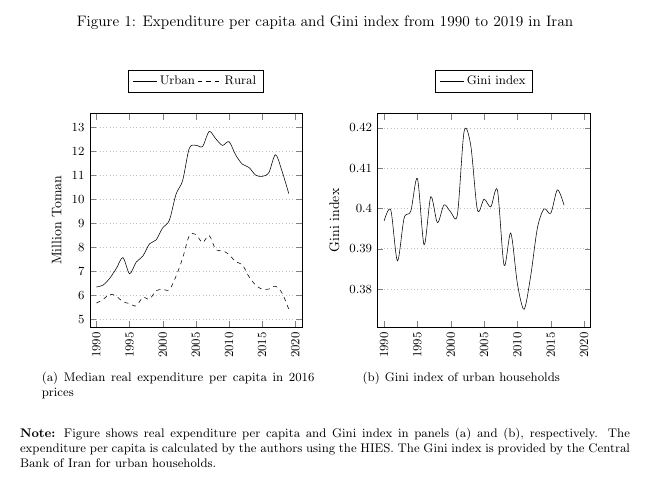

In [86]:
report_pages[18].crop((100, 300, 750, 800))

In [89]:
(
    hbsir.load_table("Total_Expenditure", years="1369-1399")
    .pipe(hbsir.add_attribute, "Urban_Rural")
)

,Year,ID,Gross_Expenditure,Net_Expenditure,Urban_Rural
0,1369,1.001000e+03,1126713.0,1126713.0,Rural
1,1369,1.002000e+03,360652.0,360652.0,Rural
2,1369,1.003000e+03,5474204.0,5474204.0,Rural
3,1369,1.004000e+03,1916863.0,1916863.0,Rural
4,1369,1.005000e+03,1250255.0,1250255.0,Rural
...,...,...,...,...,...
37552,1399,2.300671e+10,441500000.0,441500000.0,Rural
37553,1399,2.300671e+10,726881400.0,726881400.0,Rural
37554,1399,2.300671e+10,643078000.0,643078000.0,Rural
37555,1399,2.300671e+10,402300000.0,402300000.0,Rural


## Table A1: Number of removed households

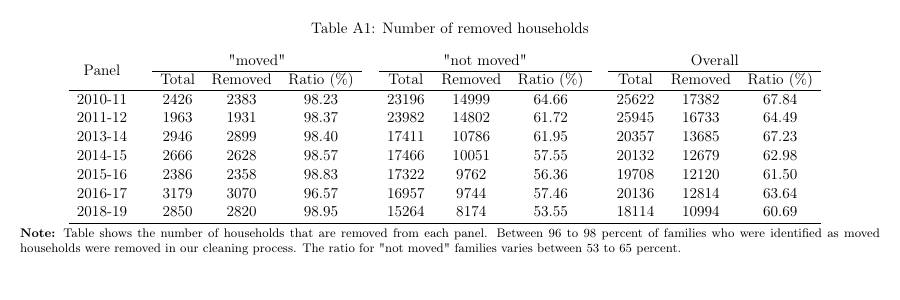

In [13]:
report_pages[32].crop((100, 100, 1000, 400))

In [14]:
table = (
    pd.concat(
        [
            panel_households,
            finel_filter,
            moving_info,
        ],
        axis="columns",
        keys=["Total", "Keeped", "Moved"],
    )
    .loc[[1390, 1391, 1393, 1394, 1395, 1396, 1398]]
    .groupby(["Moved", "Year"], observed=True).sum()
    .assign(Removed = lambda df: df["Total"] - df["Keeped"])
    .drop(columns="Keeped")
)

overall = pd.concat([table.groupby("Year").sum()], keys=["overall"], names=["Moved"])

def sort_key(columns: pd.Index) -> pd.Index:
    return columns.map(
        {
            "moved": 0,
            "not_moved": 1,
            "overall": 2,
            "Total": 3,
            "Removed": 4,
            "Ratio": 5
        }
    )

table = (
    pd.concat([table, overall])
    .assign(Ratio = lambda df: df["Removed"] / df["Total"] * 100)
    .unstack(0)
    .reorder_levels([1, 0], axis="columns")
    .sort_index(axis="columns", key=sort_key, sort_remaining=False)
    .rename_axis([None, None], axis="columns")
    .rename_axis("Panel")
)
(
    table
    .style
    .format(thousands=",")
    .format(precision=2, subset=[(cat, "Ratio") for cat in ["moved", "not_moved", "overall"]])
)